In [10]:
import json
import pandas as pd
from datetime import datetime
from fake_useragent import UserAgent
import requests
import re
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

plt.style.use('ggplot')

In [20]:
def hash_cycle(cycle):
    res = 0
    for token in cycle:
        res+=int(token,16)
    return res

In [ ]:
cycle_length = 6

# cycles distribution
we see how many different cycles compose our restrained (lenth = 3 swaps) dataset

In [22]:
all_cycles_path = "Data/cycles"

In [23]:
different_cycles = {}
for line in open(all_cycles_path):
    path = json.loads(line)["path"]
    if len(path)==cycle_length:
        cycle_hash = hash_cycle(path)
        if cycle_hash not in different_cycles:
            different_cycles[cycle_hash]=0
        different_cycles[cycle_hash]+=1

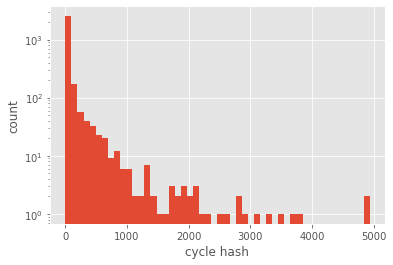

In [24]:
plt.hist(list(different_cycles.values()),bins=50)
#plt.xscale("log")
plt.yscale("log")
plt.xlabel("cycle hash")
plt.ylabel("count")
plt.show()

In [25]:
k=5
print(f"top {k} cycles and their hashs")
top_k =sorted(different_cycles.items(), key=lambda item: -item[1])[:k]
top_k

top 5 cycles and their hashs


[(4905955156809171494002422751837224513764394965760, 4931),
 (3730882822284192223036450845050968439005857317622, 4903),
 (4389807248672491020845394725943025045003422034288, 3837),
 (5013975839320635475748850689609933254072251761158, 3725),
 (3209905518692170303730419848504774004257765074842, 3458)]

In [26]:
top_k = [x[0] for x in top_k]
top_k

[4905955156809171494002422751837224513764394965760,
 3730882822284192223036450845050968439005857317622,
 4389807248672491020845394725943025045003422034288,
 5013975839320635475748850689609933254072251761158,
 3209905518692170303730419848504774004257765074842]

# Dataset filtering 

In [27]:
filtered_dataset_path = "Data/filered_cycles.json"

In [28]:
f_out = open(filtered_dataset_path,"wt")
count = 0
for line in open(all_cycles_path):
    path = json.loads(line)["path"]
    cycle_hash = hash_cycle(path)
    if len(path)==cycle_length and cycle_hash in top_k:
        f_out.write(line)
        count+=1
f_out.close()
print(count," cycles saved")

20854  cycles saved


# Node statistics

In [29]:
all_tokens  = set()
cycle_paths = []
for line in open(filtered_dataset_path):
    path = json.loads(line)["path"]
    cycle_paths.append(path)
    for token in path:
        all_tokens.add(token) 
print(len(all_tokens)," different tokens and" ,len(cycle_paths), " cycles are present in the data")

11  different tokens and 20854  cycles are present in the data


# Fetching token names

In [30]:
ua = UserAgent()
header = {'User-Agent':str(ua.chrome)}

def get_token_name(address):
    url = f"https://etherscan.io/token/{address}"
    htmlContent = requests.get(url, headers=header)
    full_name = re.search(r'<meta name="Description" content="(.*?)Token Tracker', htmlContent.text).group(1)
    token_id  =  re.search(r'\((.*?)\)', full_name).group(1)
    return token_id
address_to_name = {}
for address in all_tokens:
    address_to_name[address] = get_token_name(address)

In [31]:
address_to_name["0xdF5e0e81Dff6FAF3A7e52BA697820c5e32D806A8"] = "Curve"
address_to_name 

{'0x5BEfBB272290dD5b8521D4a938f6c4757742c430': 'XFI',
 '0x08AD83D779BDf2BBE1ad9cc0f78aa0D24AB97802': 'RWS',
 '0x037A54AaB062628C9Bbae1FDB1583c195585fe41': 'LCX',
 '0x557B933a7C2c45672B610F8954A3deB39a51A8Ca': 'REVV',
 '0x7dE91B204C1C737bcEe6F000AAA6569Cf7061cb7': 'XRT',
 '0x0e2298E3B3390e3b945a5456fBf59eCc3f55DA16': 'YAM',
 '0xdF5e0e81Dff6FAF3A7e52BA697820c5e32D806A8': 'Curve',
 '0x9b06D48E0529ecF05905fF52DD426ebEc0EA3011': 'XSP',
 '0x68A118Ef45063051Eac49c7e647CE5Ace48a68a5': '$BASED',
 '0x57Ab1ec28D129707052df4dF418D58a2D46d5f51': 'sUSD',
 '0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2': 'WETH'}

In [39]:
unique_cycles = []

for cycle in cycle_paths:
    if not cycle in unique_cycles:
        unique_cycles.append(cycle)
unique_cycles = [[address_to_name[address] for address in cycle] for cycle in unique_cycles]
unique_cycles

[['WETH', 'XRT', 'XRT', 'RWS', 'RWS', 'WETH'],
 ['WETH', 'RWS', 'RWS', 'XRT', 'XRT', 'WETH'],
 ['WETH', 'YAM', 'YAM', 'Curve', 'Curve', 'WETH'],
 ['WETH', 'Curve', 'Curve', 'YAM', 'YAM', 'WETH'],
 ['WETH', 'sUSD', 'sUSD', '$BASED', '$BASED', 'WETH'],
 ['WETH', '$BASED', '$BASED', 'sUSD', 'sUSD', 'WETH'],
 ['$BASED', 'WETH', 'WETH', 'sUSD', 'sUSD', '$BASED'],
 ['WETH', 'LCX', 'LCX', 'REVV', 'REVV', 'WETH'],
 ['WETH', 'REVV', 'REVV', 'LCX', 'LCX', 'WETH'],
 ['$BASED', 'sUSD', 'sUSD', 'WETH', 'WETH', '$BASED'],
 ['sUSD', '$BASED', '$BASED', 'WETH', 'WETH', 'sUSD'],
 ['XRT', 'RWS', 'RWS', 'WETH', 'WETH', 'XRT'],
 ['WETH', 'XFI', 'XFI', 'XSP', 'XSP', 'WETH'],
 ['WETH', 'XSP', 'XSP', 'XFI', 'XFI', 'WETH'],
 ['RWS', 'XRT', 'XRT', 'WETH', 'WETH', 'RWS'],
 ['XSP', 'XFI', 'XFI', 'WETH', 'WETH', 'XSP'],
 ['XFI', 'XSP', 'XSP', 'WETH', 'WETH', 'XFI'],
 ['LCX', 'REVV', 'REVV', 'WETH', 'WETH', 'LCX'],
 ['REVV', 'LCX', 'LCX', 'WETH', 'WETH', 'REVV'],
 ['YAM', 'Curve', 'Curve', 'WETH', 'WETH', 'YAM'],


In [56]:
def path_to_pairs(path,from_addresses = False):
    pairs = set()
    for i in range(0,int(len(path)/2),2):
        t1,t2 = sorted(path[i:i+2])
        if from_addresses:
            pairs.add(f"{address_to_name[t1]}_{address_to_name[t2]}")
        else:
            pairs.add(f"{t1}_{t2}")
    return pairs

In [57]:
pairs = set()
for path in unique_cycles:
    pairs = pairs.union(path_to_pairs(path))

In [58]:
pairs

{'$BASED_WETH',
 '$BASED_sUSD',
 'Curve_WETH',
 'Curve_YAM',
 'LCX_REVV',
 'LCX_WETH',
 'REVV_WETH',
 'RWS_WETH',
 'RWS_XRT',
 'WETH_XFI',
 'WETH_XRT',
 'WETH_XSP',
 'WETH_YAM',
 'WETH_sUSD',
 'XFI_XSP'}

# some tx hashs

In [13]:
i = 0
for line in open(filtered_dataset_path):
    transactionHash = json.loads(line)["receipt"]["logs"][0]["transactionHash"]
    print(transactionHash)
    i+=1
    if i> 10: break

NameError: name 'filtered_dataset_path' is not defined

# Fetch pools activity
https://docs.etherscan.io/api-endpoints/accounts



# Min Max block 

In [83]:
mins = {}
maxs = {}

for line in open(filtered_dataset_path):
    data =  json.loads(line)
    pairs = path_to_pairs(data["path"],from_addresses=True)
    block_numbers = [int(x["blockNumber"],16) for x in data["receipt"]["logs"]]
    for p in pairs :
        if p not in mins:
            mins[p] = np.inf
        if p not in maxs:
            maxs[p] = -np.inf
        mins[p] = min(block_numbers+[mins[p]])
        maxs[p] = max(block_numbers+[maxs[p]])
ranges = {p:(mins[p],maxs[p]) for p in mins}

In [84]:
ranges

{'XRT_WETH': (10401045, 11702035),
 'RWS_XRT': (10401045, 11706601),
 'RWS_WETH': (10401082, 11706601),
 'YAM_Curve': (10642027, 11707754),
 'YAM_WETH': (10642027, 11707754),
 'WETH_Curve': (10642111, 11707711),
 'sUSD_WETH': (10694309, 11680635),
 'sUSD_$BASED': (10694309, 11709002),
 '$BASED_WETH': (10694428, 11709002),
 'LCX_WETH': (10821194, 11707777),
 'LCX_REVV': (10821194, 11709662),
 'REVV_WETH': (10821224, 11709662),
 'XFI_XSP': (10895389, 11644328),
 'XFI_WETH': (10895389, 11505775),
 'XSP_WETH': (10895392, 11644328)}

In [85]:
for p in ranges:
    print(p, " spans over : ",ranges[p][1]-ranges[p][0]," blocks")

XRT_WETH  spans over :  1300990  blocks
RWS_XRT  spans over :  1305556  blocks
RWS_WETH  spans over :  1305519  blocks
YAM_Curve  spans over :  1065727  blocks
YAM_WETH  spans over :  1065727  blocks
WETH_Curve  spans over :  1065600  blocks
sUSD_WETH  spans over :  986326  blocks
sUSD_$BASED  spans over :  1014693  blocks
$BASED_WETH  spans over :  1014574  blocks
LCX_WETH  spans over :  886583  blocks
LCX_REVV  spans over :  888468  blocks
REVV_WETH  spans over :  888438  blocks
XFI_XSP  spans over :  748939  blocks
XFI_WETH  spans over :  610386  blocks
XSP_WETH  spans over :  748936  blocks


In [3]:
API_KEY = "719J19A1G4KIXBP2CP8ADRYBJQ2JQBCMVA"

In [97]:
# found them manually
pool_addresses = { "XRT_WETH" : "0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2?a=0x3185626c14acb9531d19560decb9d3e5e80681b1"
    
}


In [11]:
pair_name = "XRT_WETH"
min_b,max_b = 0,10401045

a = "0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2"
req = f"https://api.etherscan.io/api?module=account&action=txlist&address={a}&startblock={min_b}&endblock={max_b}&page=1&offset=100&sort=desc&apikey={API_KEY}"
req

'https://api.etherscan.io/api?module=account&action=txlist&address=0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2&startblock=0&endblock=10401045&page=1&offset=100&sort=desc&apikey=719J19A1G4KIXBP2CP8ADRYBJQ2JQBCMVA'

In [12]:
requests.get(req).json()


{'status': '1',
 'message': 'OK',
 'result': [{'blockNumber': '10401018',
   'timeStamp': '1593973928',
   'hash': '0xc3229c448a425d3ab9da7972a4ab703eb14b8a092aa59c7eaea6aaf387030b6c',
   'nonce': '138',
   'blockHash': '0xf57cd705693b8d366be6c22117d0f66633be3999a2fd1b9812526872a426575e',
   'transactionIndex': '30',
   'from': '0xa21392dd4b12cb543fb6d1e4e8759b3ac6e55169',
   'to': '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2',
   'value': '210000000000000000000',
   'gas': '43738',
   'gasPrice': '20000000000',
   'isError': '0',
   'txreceipt_status': '1',
   'input': '0xd0e30db0',
   'contractAddress': '',
   'cumulativeGasUsed': '11828140',
   'gasUsed': '43738',
   'confirmations': '3309409'},
  {'blockNumber': '10400988',
   'timeStamp': '1593973546',
   'hash': '0x868cf7154f46664c72c84cd83fd5d5803b294c8d36812284ef594f5b95d7f646',
   'nonce': '14230',
   'blockHash': '0xfc5bca3c187212a377cf96877df884cfc9a5014c4c13c1c58cec3fecd3d68baf',
   'transactionIndex': '93',
   'from': '0x7b

In [104]:
min_b

10401045

In [ ]:
pair_name = "XRT_WETH"
min_b,max_b = ranges[pair_name]
req = f"https://api.etherscan.io/api?module=account&action=txlist&address={pool_addresses[pair_name]}&startblock={min_b-10}&endblock={min_b+1}&page=1&offset=10000&sort=asc&apikey={API_KEY}"

In [89]:
pool_address = "0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2?a=0x3185626c14acb9531d19560decb9d3e5e80681b1"
url = f"https://api.etherscan.io/api?module=account&action=txlist&address={pool_address}&sort=asc"

In [1]:
a = "0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2"
f"https://api.etherscan.io/api?module=account&action=txlist&address={a}&sort=asc"

'https://api.etherscan.io/api?module=account&action=txlist&address=0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2&sort=asc'

In [91]:
datetime.fromtimestamp(1632347987)

datetime.datetime(2021, 9, 22, 23, 59, 47)

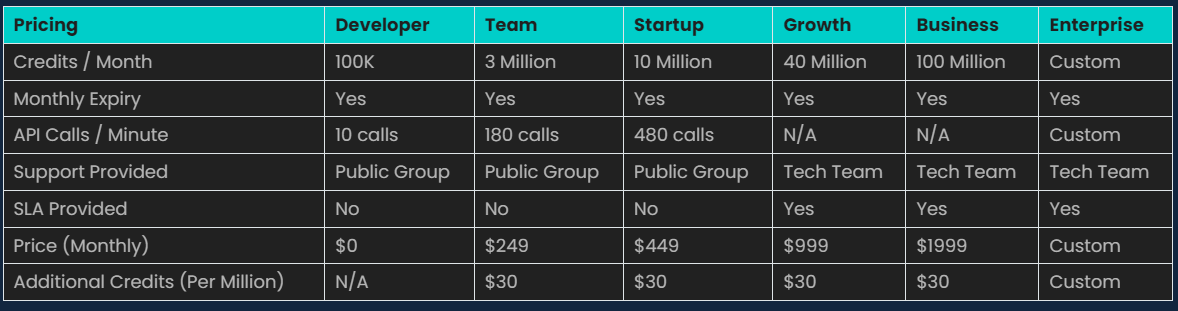

In [ ]:
{
  swap(id : "0x2ec2e027c93f2e8c5dd0522387894a1524b046310f0d4906c85f08ede16264d7-0")
  {
    amount0In
    amount1In
    amount0Out
    amount1Out
    }
  }

In [ ]:
{
  transaction(id : "0x2ec2e027c93f2e8c5dd0522387894a1524b046310f0d4906c85f08ede16264d7"){
    id 
    blockNumber
    timestamp
    swaps {
      id
    }
  }
  
}